### Split-data
#### Creating a test set 80/20
Because the data generated is time-sensitive we categorize the data into 'night', 'morning', 'afternoon', 'evening' then perform strattified sampling on each category.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
import statsmodels.api as smg
import seaborn as sns

In [2]:
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
merged_df = pd.read_parquet("data/04merged-with-trip-duration-pickup-cat")
merged_df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun,trip_duration,pickup_time_cat
0,1,2020-01-01 00:28:15,2020-01-01 00:33:03,1.0,1.2,1.0,N,238,239,1,...,5.0,NaN,NaN,NaN,17.3,NaN,1008.2,NaN,0 days 00:04:48,night
1,1,2020-01-01 00:35:39,2020-01-01 00:43:04,1.0,1.2,1.0,N,239,238,1,...,5.0,NaN,NaN,NaN,17.3,NaN,1008.2,NaN,0 days 00:07:25,night
2,1,2020-01-01 00:47:41,2020-01-01 00:53:52,1.0,0.6,1.0,N,238,238,1,...,5.0,NaN,NaN,NaN,17.3,NaN,1008.2,NaN,0 days 00:06:11,night
3,1,2020-01-01 00:55:23,2020-01-01 01:00:14,1.0,0.8,1.0,N,238,151,1,...,5.0,NaN,NaN,NaN,17.3,NaN,1008.2,NaN,0 days 00:04:51,night
4,2,2020-01-01 00:01:58,2020-01-01 00:04:16,1.0,0.0,1.0,N,193,193,2,...,5.0,NaN,NaN,NaN,17.3,NaN,1008.2,NaN,0 days 00:02:18,night


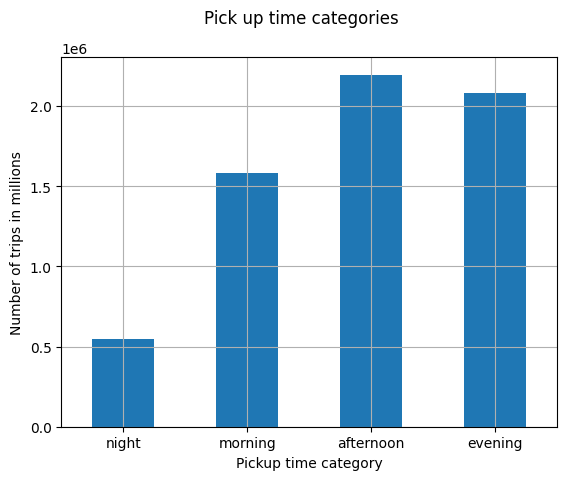

In [4]:
merged_df['pickup_time_cat'].value_counts().sort_index().plot.bar(rot=0, grid=True)
plt.xlabel("Pickup time category")
plt.ylabel("Number of trips in millions")
plt.suptitle("Pick up time categories")
plt.show()

In [5]:
from sklearn.model_selection import StratifiedShuffleSplit

# 10 splits of 60/20 and set random_state for deterministic samples
splitter = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
strat_splits = []
for train_index, test_index in splitter.split(merged_df, merged_df["pickup_time_cat"]):
    strat_train_set_n = merged_df.iloc[train_index]
    strat_test_set_n = merged_df.iloc[test_index]
    strat_splits.append([strat_train_set_n, strat_test_set_n])

The splitter.split() will yeild training and test indeces not the data itself.

In [6]:
strat_train_set, strat_test_set = strat_splits[0]
strat_train_set.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun,trip_duration,pickup_time_cat
5629127,2,2020-01-29 13:36:22,2020-01-29 13:43:14,1.0,1.23,1.0,N,238,166,2,...,7.2,NaN,NaN,NaN,7.8,NaN,1018.2,NaN,0 days 00:06:52,afternoon
3950490,2,2020-01-19 12:04:41,2020-01-19 12:08:42,2.0,1.01,1.0,N,141,263,1,...,7.2,NaN,NaN,NaN,10.2,NaN,1008.9,NaN,0 days 00:04:01,afternoon
3215978,2,2020-01-16 00:18:38,2020-01-16 00:26:17,1.0,1.49,1.0,N,161,50,2,...,10.0,NaN,NaN,NaN,10.6,NaN,1015.1,NaN,0 days 00:07:39,night
2139620,1,2020-01-10 22:49:59,2020-01-10 23:08:07,1.0,4.80,1.0,N,230,74,1,...,11.7,NaN,NaN,265.0,14.5,NaN,1034.5,NaN,0 days 00:18:08,evening
69250,2,2020-01-01 09:45:34,2020-01-01 09:58:58,6.0,1.16,1.0,N,164,90,2,...,5.0,NaN,NaN,NaN,17.3,NaN,1008.2,NaN,0 days 00:13:24,morning


Can see the randoms in achieved by random sampling

##### checking sampling results
Comparing the pickup-time category proportions in the overal dataset in a test set using stratified sampling and one using purely random sampling

In [7]:
# Comparing the pickup-time category proportions in the overal dataset in a test set using stratified sampling and one using purely random sampling
def income_cat_proportions(data):
    return data["pickup_time_cat"].value_counts() / len(data)

In [8]:
# compare stratified sampling to other methods
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(merged_df, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall %": income_cat_proportions(merged_df),
    "Stratified %": income_cat_proportions(strat_test_set),
    "Random %": income_cat_proportions(test_set),
}).sort_index()
compare_props.index.name = "Pick up time Category"
compare_props["Stratified Error %"] = (compare_props["Stratified %"] / compare_props["Overall %"] - 1)
compare_props["Random Error %"] = (compare_props["Random %"] / compare_props["Overall %"] - 1)
(compare_props * 100).round(2)

,Overall %,Stratified %,Random %,Stratified Error %,Random Error %
Pick up time Category,,,,,
night,8.52,8.52,8.56,-0.0,0.41
morning,24.73,24.73,24.76,-0.0,0.12
afternoon,34.27,34.27,34.26,-0.0,-0.02
evening,32.48,32.48,32.42,0.0,-0.18


As can be seen the test set generated using stratified sampling ha pick up category proportions approximately identical to those in full dataset however set generated using just random sampling is skewed

In [ ]:
# ageter splitting no need for the pickup_time_cat therefore drop it
for set_ in (strat_train_set, strat_test_set):
    set_.drop("pickup_time_cat", axis=1, inplace=True)

#### Pickle the strattified splits

In [10]:
# save the strat_splits to save memory
for i, data_set in enumerate(strat_splits):
    for j, df in enumerate(data_set):
        df.to_pickle(f'pickled-data/df_{i}-{j}.pkl')

In [ ]:
# read pickled data
strat_splits = []
for i in range(10):
    split = []
    for j in range(2):
        split.append(pd.read_pickle(f'pickled-data/df_{i}-{j}.pkl'))
    strat_splits.append(split)
print("Confirm 10 stratified splits pickled.  No of splits = ", len(strat_splits))

In [12]:
strat_train_set, strat_test_set = strat_splits[0]
strat_train_set.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun,trip_duration
5629127,2,2020-01-29 13:36:22,2020-01-29 13:43:14,1.0,1.23,1.0,N,238,166,2,...,1.1,7.2,NaN,NaN,NaN,7.8,NaN,1018.2,NaN,0 days 00:06:52
3950490,2,2020-01-19 12:04:41,2020-01-19 12:08:42,2.0,1.01,1.0,N,141,263,1,...,0.6,7.2,NaN,NaN,NaN,10.2,NaN,1008.9,NaN,0 days 00:04:01
3215978,2,2020-01-16 00:18:38,2020-01-16 00:26:17,1.0,1.49,1.0,N,161,50,2,...,2.2,10.0,NaN,NaN,NaN,10.6,NaN,1015.1,NaN,0 days 00:07:39
2139620,1,2020-01-10 22:49:59,2020-01-10 23:08:07,1.0,4.80,1.0,N,230,74,1,...,1.1,11.7,NaN,NaN,265.0,14.5,NaN,1034.5,NaN,0 days 00:18:08
69250,2,2020-01-01 09:45:34,2020-01-01 09:58:58,6.0,1.16,1.0,N,164,90,2,...,1.7,5.0,NaN,NaN,NaN,17.3,NaN,1008.2,NaN,0 days 00:13:24
